Digitizing handwriting is important for many industries, perhaps most notably post-offices, which have to sort millions of parcels a year. Teaching computers to read handwriting has been very successful in large part due to the improvement of certain machine learning techniques such as artificial neural networks (ANN); hidden Markov models (HMM); and support vector machines (SVM).

This document explores two simple machine learning methods for for classifying handwritten digits.The first is K-nearest neighbors and second is Naive Bayes, and both are used more for the purpose of developing an understanding of the algorithms than for accuracy as other techniques will perform with greater accuracy.

The subsections are:
Handwritten digit data exploration

Bayes classifier example in plain english
Let's say we have an image of a handwritten digit and we want to assign a probability that the digit is a 5. We would calculate this probability by first calculating the **likelihood** of whether or not each pixel will be dark (ie containing part of 5's pen stroke) or light (not containing part of the 5's pen stroke). We would also calculate the **prior**, which in our case is the frequency of 5 occurences in our set of images. Finally we would calculate a **normalization constant** which is simply the probability of observing all the pixels in their current dark/light state.
$$ P(Y|X_1, ..., X_n) = P(X_1, ..., X_n|Y)P(Y) / P(X_1, ..., X_n) $$

In [1]:
# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

%matplotlib inline # plot images inline

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

C:\Users\Z\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Z\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
UsageError: unrecognized arguments: # plot images inline

In [2]:
# Loading the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


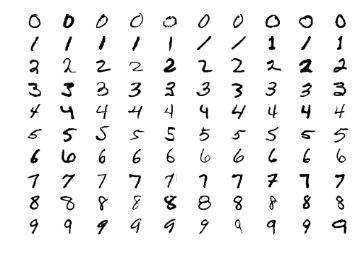

In [7]:
def visualize_data(num_examples, data_labels, data):

    indexes = list()
    for i in range(10):
        indexes.extend(np.where(data_labels == i)[0][0:num_examples])
    fig, axs = plt.subplots(nrows = 10, ncols = num_examples) # create figure and assign subplot objects to axs
    axs = axs.ravel() # returns a contiguous flattened array
    for i in range(len(indexes)):
        axs[i].imshow(data[indexes[i]].reshape(28,28), cmap='Greys')
        axs[i].axis('off')
    plt.show()

visualize_data(10, data_labels = train_labels, data = train_data)

Let's start by looking at a K-Nearest Neighbors model for clasifying the handwritten digits. We will be training using only part of the training set, and evaluation on the development set.

In [20]:
k_values = [1, 3, 5, 7, 9]
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(mini_train_data, mini_train_labels)
    accuracy = accuracy_score(y_true = dev_labels, y_pred = neigh.predict(dev_data)) # dev is for development
    if k == 1:
        print(classification_report(y_true = dev_labels, 
                                    y_pred = neigh.predict(dev_data)))
    print('k = ', k, '; accuracy = ', accuracy, sep = '')

             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95       106
        1.0       0.81      0.98      0.89        85
        2.0       0.98      0.83      0.90       101
        3.0       0.83      0.92      0.87        92
        4.0       0.86      0.81      0.84       102
        5.0       0.90      0.77      0.83        94
        6.0       0.94      0.98      0.96        89
        7.0       0.89      0.95      0.92       107
        8.0       0.88      0.80      0.84        99
        9.0       0.81      0.82      0.82       125

avg / total       0.88      0.88      0.88      1000

k = 1; accuracy = 0.88
k = 3; accuracy = 0.878
k = 5; accuracy = 0.876
k = 7; accuracy = 0.867
k = 9; accuracy = 0.86


The accuracies are surprisingly good considering the simplicity of the algorithm. Based on the F1 score, digit 9 is the most difficult digit to predict accurately for most of the k-nearest neighbor fits. The accuracy of prediction on the development set decreases as k increases. 

Let's explore the effect of training set size on accuracy and the the amount of time needed to train.

In [64]:
def variable_train_sizes_knn(train_sizes, accuracies):
    accuracies = list()
    times = list()
    for train_size in train_sizes:
        neigh = KNeighborsClassifier(n_neighbors = 1)
        neigh.fit(train_data[0:train_size], train_labels[0:train_size])
        time_start = time.time()
        y_pred = neigh.predict(dev_data)
        time_fin = time.time()
        time_s = (time_fin-time_start)
        accuracy = accuracy_score(y_true = dev_labels, y_pred = y_pred)
        # print("training size %s has an accuracy of %0.2f and took %0.3f s to complete" % (train_size, accuracy, time_s))
        accuracies.append(accuracy)
        times.append(time_s)
    return(accuracies, times)

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
accuracies, times = variable_train_sizes_knn(train_sizes, accuracies)

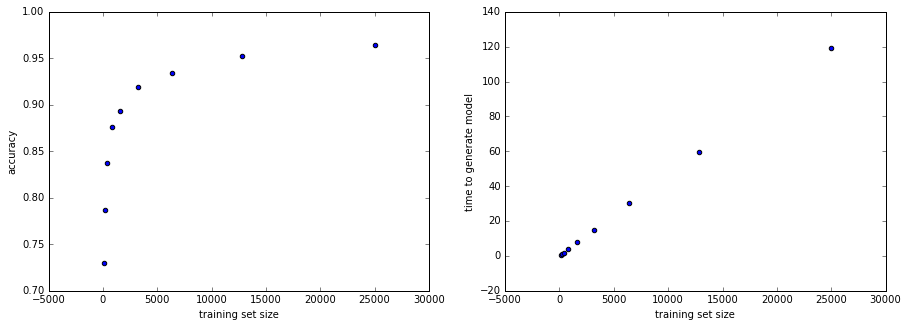

In [47]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
axs[0].scatter(x = train_sizes, y = accuracies)
axs[0].set_xlabel('training set size')
axs[0].set_ylabel('accuracy')

axs[1].scatter(x = train_sizes, y = times)
axs[1].set_xlabel('training set size')
axs[1].set_ylabel('time to generate model')
plt.show()

These result show that the time to generate the model is essentially linear with respect to training set size, but the return on improved accuracy is minimal after 10,000 training observations. By a training set size of 12,800 we've already reached an accuracy of 95% on development data.

Out of curiosity, lets look at the nearest neighbors for some randomly chosen digits.

In [57]:
neigh.kneighbors([train_data[0]])

(array([[ 0.        ,  5.86938964,  5.92536302,  6.0967693 ,  6.11665527,
          6.12262367,  6.17991563,  6.19257657,  6.2337993 ]]),
 array([[  0, 649, 887, 204, 261, 551, 511, 661, 579]], dtype=int64))

The true label is 4.0 and the 9 nearest neighbors are:


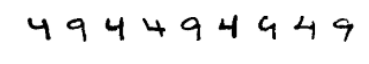

In [73]:
neigh = KNeighborsClassifier(n_neighbors = 9)
neigh.fit(mini_train_data, mini_train_labels)
fig, axs = plt.subplots(ncols = 9) # create figure and assign subplot objects to axs
axs = axs.ravel() # returns a contiguous flattened array
print("The true label is", mini_train_labels[1], "and the 9 nearest neighbors are:")
for i, j in enumerate(neigh.kneighbors([mini_train_data[1]])[1][0]):
    axs[i].imshow(mini_train_data[j].reshape(28,28), cmap='Greys')
    axs[i].axis('off') 

This shows us that although 5/9 nearest neighbors are of the correct class, 4/9 are not. 

[[102   0   0   0   0   2   1   0   1   0]
 [  0  83   1   0   0   0   0   1   0   0]
 [  2   4  84   1   1   2   1   1   3   2]
 [  0   0   0  85   0   2   0   0   5   0]
 [  0   3   0   0  83   0   0   0   0  16]
 [  0   1   0  14   0  72   3   0   1   3]
 [  1   1   0   0   0   0  87   0   0   0]
 [  0   2   0   0   2   0   0 102   0   1]
 [  2   7   0   3   1   2   1   2  79   2]
 [  1   1   1   0   9   0   0   9   1 103]]


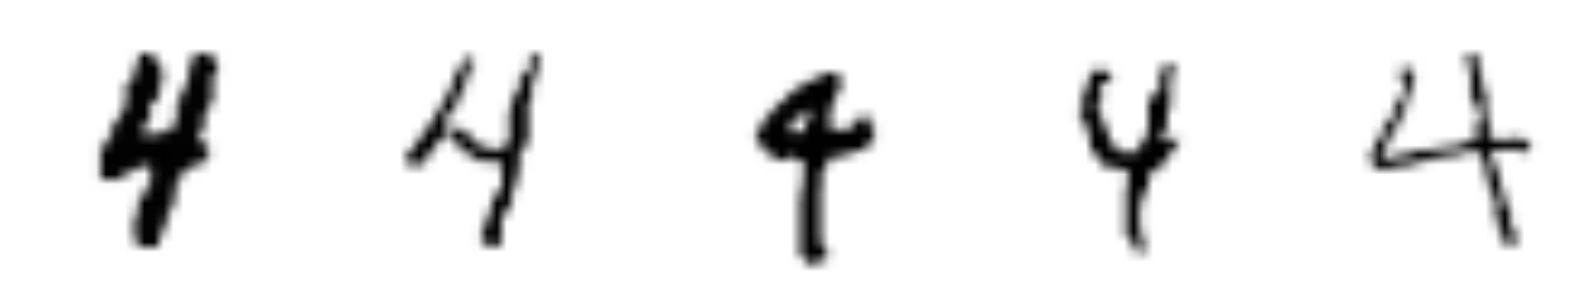

In [74]:
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(mini_train_data, mini_train_labels)
pred = neigh.predict(dev_data)

print(confusion_matrix(y_true = dev_labels, y_pred = pred))

confused_pairs = np.where((pred != dev_labels)) # these are the predicted array's indexes at which the number predicted was wrong

# confused_pred are the predicted values confused digits (ie those it got wrong)
confused_pred = pred[confused_pairs] 

# now the indexes from the confused_pred are collected
nine_but_shoulda_been_four_confused_pred_indexes = np.intersect1d(np.where(pred[confused_pairs] == 9), 
                                                          np.where(dev_labels[confused_pairs] == 4))

# to get the data for these specific predictions I need to repeat the steps on the dev_data
dev_confused_data = dev_data[confused_pairs]

# nine_but_shoulda_been_four_data are the predictived 9 values, which are in truth 4s
nine_but_shoulda_been_four_data = dev_confused_data[nine_but_shoulda_been_four_confused_pred_indexes]

# plotting first 5 examples
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (28,28))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(nine_but_shoulda_been_four_data[i].reshape(28,28), cmap = 'Greys')
    axs[i].axis('off')

In [ ]:
This gave us an idea of how K-nearest neighbors will perform. Let's compare it to Naive Bayes.